# 1. IMPORT LIBRARIES + READ CSV

# RUN WITH TPU

In [1]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 48.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 78.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 44.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 61.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 5.2 MB/s eta 0:00:00


# 1. Imports load etc

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
#import statsmodels.api as sm
#from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
#import statsmodels.graphics.tsaplots as sgt

from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout


In [4]:
from tensorflow.keras import regularizers

In [5]:
import os
from google.colab import drive
drive.mount('/content/gdrive')

# Change working directory to be current folder
# os.chdir('/content/gdrive/My Drive/Your Folder Name/Your sub Folder Name')
os.chdir('/content/gdrive/My Drive/Proj5005')
!ls

Mounted at /content/gdrive
'1month(EDA).ipynb'		 frame_3_E.png
 2024_UBER.ipynb		 frame_3_S.png
 adjacency.csv			 frame_4_E.png
 ARIMA_by_borough_hol_we.ipynb	 frame_4_S.png
 ARIMA_byhour.ipynb		 locations_Manhattan.csv
 Data				 LSTM_byBorough
 data_preprocessed		 LSTM_by_location.ipynb
'D&D'				'LSTM Model'
 ExploreShapeFile.ipynb		 MC_Simulation
 Final_ARIMA			'Peak non-peak analysis.ipynb'
 Final_LSTM			 SARIMAX_byhour.ipynb
 frame_1_E.png			 sim_Trips_simple.csv
 frame_1_S.png			 taxi_zones_shapefile
 frame_2_E.png			 TEST_LSTM_by_location.ipynb
 frame_2_S.png			 TS_Workshops


# Manhattan

In [6]:
df_man = pd.read_csv("LSTM_byBorough/Manhattan.csv")

In [7]:
df_man

,datetime_hour,PULocationID,order_count,LocationID,Borough
0,2023-01-01 00:00:00,4,190.0,4,Manhattan
1,2023-01-01 00:00:00,12,9.0,12,Manhattan
2,2023-01-01 00:00:00,13,133.0,13,Manhattan
3,2023-01-01 00:00:00,24,87.0,24,Manhattan
4,2023-01-01 00:00:00,41,343.0,41,Manhattan
...,...,...,...,...,...
1175443,2024-12-31 23:00:00,246,264.0,246,Manhattan
1175444,2024-12-31 23:00:00,249,418.0,249,Manhattan
1175445,2024-12-31 23:00:00,261,111.0,261,Manhattan
1175446,2024-12-31 23:00:00,262,109.0,262,Manhattan


# Preprocess

In [8]:
# Normalize
scaler = MinMaxScaler()
df_man['order_count_mm'] = scaler.fit_transform(df_man[['order_count']])

In [9]:
df_man

,datetime_hour,PULocationID,order_count,LocationID,Borough,order_count_mm
0,2023-01-01 00:00:00,4,190.0,4,Manhattan,0.067592
1,2023-01-01 00:00:00,12,9.0,12,Manhattan,0.003202
2,2023-01-01 00:00:00,13,133.0,13,Manhattan,0.047314
3,2023-01-01 00:00:00,24,87.0,24,Manhattan,0.030950
4,2023-01-01 00:00:00,41,343.0,41,Manhattan,0.122021
...,...,...,...,...,...,...
1175443,2024-12-31 23:00:00,246,264.0,246,Manhattan,0.093917
1175444,2024-12-31 23:00:00,249,418.0,249,Manhattan,0.148702
1175445,2024-12-31 23:00:00,261,111.0,261,Manhattan,0.039488
1175446,2024-12-31 23:00:00,262,109.0,262,Manhattan,0.038776


In [10]:
def pivot_demand_by_location(df, time_col='time', location_col='location', demand_col='demand'):
    """
    Pivots the DataFrame to create separate demand columns for each location.

    Args:
        df (pd.DataFrame): The DataFrame to pivot.
        time_col (str): The name of the time column.
        location_col (str): The name of the location column.
        demand_col (str): The name of the demand column.

    Returns:
        pd.DataFrame: The pivoted DataFrame.
    """

    if not all(col in df.columns for col in [time_col, location_col, demand_col]):
        raise ValueError("One or more specified columns not found in DataFrame.")

    pivoted_df = df.pivot_table(index=time_col, columns=location_col, values=demand_col, aggfunc='sum')
    pivoted_df = pivoted_df.reset_index() #makes the time column a regular column, not the index
    return pivoted_df


In [11]:
df_pivoted = pivot_demand_by_location(df_man, 'datetime_hour', 'PULocationID', 'order_count_mm')

In [12]:
#df_pivoted

# Preprocess Add more factors

In [13]:
#df_pivoted = pivot_demand_by_location(df, 'datetime_hour', 'PULocationID', 'order_count_mm')

In [14]:
df_pivoted['datetime_hour'] = pd.to_datetime(df_pivoted['datetime_hour'])
df_pivoted['is_weekend'] = df_pivoted['datetime_hour'].dt.weekday.isin([5, 6])


df_hol = pd.read_csv("data_preprocessed/NYC_Holidays_23_24.csv")

df_hol['Holidays'] = pd.to_datetime(df_hol['Holidays'])
df_pivoted['date'] = df_pivoted['datetime_hour'].dt.date
df_pivoted['date']  = pd.to_datetime(df_pivoted['date'])
df_pivoted['is_holiday'] = df_pivoted['date'].isin(df_hol['Holidays'])

df_pivoted.drop(columns=['date'], inplace=True)

df_pivoted['hour'] = df_pivoted['datetime_hour'].dt.hour
df_pivoted['day'] = df_pivoted['datetime_hour'].dt.weekday
df_pivoted['month'] = df_pivoted['datetime_hour'].dt.month

# Normalize
scaler_temp = MinMaxScaler()
df_pivoted['hour'] = scaler_temp.fit_transform(df_pivoted[['hour']])
df_pivoted['day'] = scaler_temp.fit_transform(df_pivoted[['day']])
df_pivoted['month'] = scaler_temp.fit_transform(df_pivoted[['month']])

df_pivoted['is_weekend'] = df_pivoted['is_weekend'].astype(int)
df_pivoted['is_holiday'] = df_pivoted['is_holiday'].astype(int)

#TEST
df_pivoted

<ipython-input-14-90867131dfe7>:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_hol['Holidays'] = pd.to_datetime(df_hol['Holidays'])


PULocationID,datetime_hour,4,12,13,24,41,42,43,45,48,...,246,249,261,262,263,is_weekend,is_holiday,hour,day,month
0,2023-01-01 00:00:00,0.067592,0.003202,0.047314,0.030950,0.122021,0.117752,0.049449,0.046603,0.170402,...,0.175738,0.221274,0.034863,0.073995,0.119175,1,0,0.000000,1.000000,0.0
1,2023-01-01 01:00:00,0.070793,0.001067,0.037353,0.023835,0.130203,0.138385,0.039488,0.050516,0.203131,...,0.210601,0.168623,0.044824,0.068659,0.134116,1,0,0.043478,1.000000,0.0
2,2023-01-01 02:00:00,0.063678,0.000356,0.020633,0.023123,0.110281,0.159730,0.018143,0.051939,0.210245,...,0.187834,0.179651,0.058342,0.048026,0.123088,1,0,0.086957,1.000000,0.0
3,2023-01-01 03:00:00,0.074351,0.000000,0.017432,0.022056,0.097474,0.157595,0.007471,0.064034,0.195304,...,0.119530,0.163999,0.049449,0.033440,0.083956,1,0,0.130435,1.000000,0.0
4,2023-01-01 04:00:00,0.052650,0.000356,0.009249,0.016009,0.069370,0.104233,0.004980,0.037353,0.154749,...,0.104233,0.086802,0.040555,0.021345,0.043401,1,0,0.173913,1.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17539,2024-12-31 19:00:00,0.083244,0.000356,0.074351,0.031306,0.138741,0.185343,0.020989,0.042689,0.127357,...,0.131270,0.153326,0.069726,0.109925,0.150480,0,0,0.826087,0.166667,1.0
17540,2024-12-31 20:00:00,0.114194,0.000711,0.082533,0.038776,0.113838,0.192458,0.018143,0.076485,0.173604,...,0.174315,0.261117,0.081110,0.119530,0.154393,0,0,0.869565,0.166667,1.0
17541,2024-12-31 21:00:00,0.136250,0.000711,0.071861,0.032729,0.146567,0.219495,0.012095,0.071505,0.176450,...,0.179651,0.297047,0.084312,0.103166,0.163287,0,0,0.913043,0.166667,1.0
17542,2024-12-31 22:00:00,0.131270,0.000000,0.057986,0.029527,0.138029,0.212380,0.008894,0.078620,0.194948,...,0.150125,0.317325,0.068303,0.093561,0.156528,0,0,0.956522,0.166667,1.0


# Create Sequences for 24 hours in advance

In [15]:
def create_sequences(data, to_add_X, to_drop_y, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length - 23):
        sequence = data.iloc[i:i + seq_length].drop(columns=to_drop_y).values
        added_columns = data.iloc[i + seq_length + 23][to_add_X].values  # Extract added columns
        #X.append(np.concatenate((sequence, added_columns.reshape(1, -1)), axis=1))  # Concatenate along columns
        added_columns = np.repeat(added_columns.reshape(1, -1), seq_length, axis=0)
        X.append(np.concatenate((sequence, added_columns), axis=1))  # Concatenate along columns
        y.append(data.drop(columns=to_drop_y).iloc[i + seq_length + 23])

    return np.array(X), np.array(y)

In [16]:
to_add_X = ['is_weekend','is_holiday','hour','day','month']
to_drop_y = ['datetime_hour','is_weekend','is_holiday','hour','day','month']
X_f, y_f = create_sequences(df_pivoted, to_add_X, to_drop_y, 10)

# Model and Train

# Split train

In [17]:
print("Shape of X: ",X_f.shape)
print ("Shape of y: ",y_f.shape)

Shape of X:  (17511, 10, 72)
Shape of y:  (17511, 67)


In [18]:
# 4. Train-Test Split
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(X_f, y_f, test_size=0.2, shuffle=False)
print("Shape of X_train: ", X_train_f.shape)
print("Shape of X_test: ",X_test_f.shape)
print ("Shape of y_train: ",y_train_f.shape)
print ("Shape of y_test: ",y_test_f.shape)

Shape of X_train:  (14008, 10, 72)
Shape of X_test:  (3503, 10, 72)
Shape of y_train:  (14008, 67)
Shape of y_test:  (3503, 67)


In [19]:
X_train_f = X_train_f.astype(np.float32)
y_train_f = y_train_f.astype(np.float32)
X_test_f = X_test_f.astype(np.float32)
y_test_f = y_test_f.astype(np.float32)

In [20]:

SEED = 42
tf.random.set_seed(SEED)

model_f = Sequential([
    LSTM(64, activation="tanh", return_sequences=True, input_shape=(X_train_f.shape[1], X_train_f.shape[2])),
    LSTM(32, activation="tanh"),
    Dense(16, activation="relu"),
    Dense(32, activation="relu"),
    Dense(64, activation="relu"),
    Dropout(0.2),
    Dense(y_train_f.shape[1], activation="sigmoid")
])

model_f.compile(optimizer='adam', loss='mse')

hist= model_f.fit(X_train_f, y_train_f, epochs=1000, batch_size=1024, validation_data=(X_test_f, y_test_f))


Epoch 1/1000


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 262ms/step - loss: 0.1924 - val_loss: 0.1512
Epoch 2/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 185ms/step - loss: 0.1257 - val_loss: 0.0436
Epoch 3/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 173ms/step - loss: 0.0370 - val_loss: 0.0063
Epoch 4/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 172ms/step - loss: 0.0091 - val_loss: 0.0039
Epoch 5/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 175ms/step - loss: 0.0054 - val_loss: 0.0040
Epoch 6/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 173ms/step - loss: 0.0049 - val_loss: 0.0038
Epoch 7/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 172ms/step - loss: 0.0046 - val_loss: 0.0035
Epoch 8/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 172ms/step - loss: 0.0044 - val_loss: 0.0031
Epoch 9/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 204ms/step - loss: 0.0041 - val_loss: 0.0028
Epoch 10/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 212ms/step - loss: 0.0039 - val_loss: 0.0025
Epoch 11/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 218ms/step - loss: 0.0038 - val_loss: 0.0023
Epoch 12/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s

# Examine Epochs Plot and See

In [21]:
def plot_loss(history, start_epoch=0, end_epoch=None):
    """Plots the training and validation loss from a Keras history object for a specified epoch range."""

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    if end_epoch is None:
        end_epoch = len(loss)  # Plot all epochs if end_epoch is not specified

    epochs = range(start_epoch, end_epoch)

    plt.plot(epochs, loss[start_epoch:end_epoch], label='loss')
    plt.plot(epochs, val_loss[start_epoch:end_epoch], label='val_loss')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

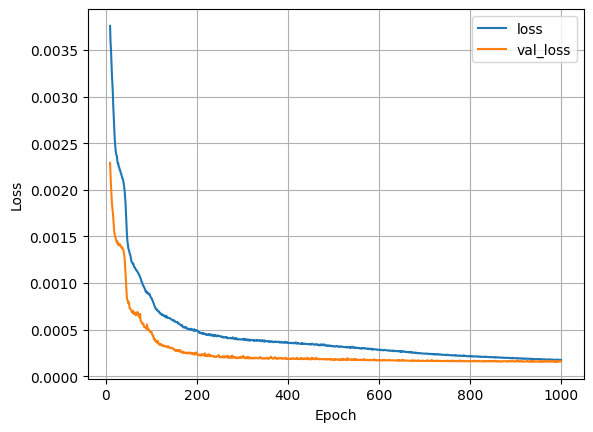

In [22]:

plot_loss(hist,10,1000)

# Predictions

In [ ]:
'''
from tensorflow.keras.models import load_model

model_f = load_model('LSTM Model/5005_LSTM_Model_8APR.keras')
'''

In [23]:
# 7. Make Predictions (Remember to Inverse Transform)
preds_f = model_f.predict(X_test_f)

110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


In [24]:
preds_f.shape

(3503, 67)

In [25]:
preds_f_t = scaler.inverse_transform(preds_f)

In [26]:
y_test_f_t = scaler.inverse_transform(y_test_f)

In [27]:
MSE_N = mean_squared_error(y_test_f, preds_f)
MSE = mean_squared_error(y_test_f_t, preds_f_t)
RMSE_N = root_mean_squared_error(y_test_f, preds_f)
RMSE = root_mean_squared_error(y_test_f_t, preds_f_t)
#print("MSE Normalised Values:", MSE_N)
print("MSE Actual Values:", MSE)
#print("RMSE Normalised Values:", RMSE_N)
print("RMSE Actual Values:", RMSE)

MSE Actual Values: 1250.3602294921875
RMSE Actual Values: 31.679203033447266


# Plot Results

In [28]:
def plot_test_vs_pred(y_test, y_pred, title="Test vs. Predicted"):
    """
    Plots y_test and y_pred in the same graph for comparison.

    Args:
        y_test (array-like): Test target values.
        y_pred (array-like): Predicted values.
        title (str): Title of the plot.
    """

    plt.figure(figsize=(12, 6))  # Adjust figure size as needed

    plt.plot(y_test, label='y_test', marker='o')  # Plot y_test with markers
    plt.plot(y_pred, label='y_pred', marker='x')  # Plot y_pred with markers

    plt.title(title)
    plt.xlabel('Data Points (Test Set)')
    plt.ylabel('Values')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot with test vs predicted

In [29]:
locations = df_man['PULocationID'].unique().astype(str)

In [30]:
locations = np.char.add('Loc_', locations)
locations

array(['Loc_4', 'Loc_12', 'Loc_13', 'Loc_24', 'Loc_41', 'Loc_42',
       'Loc_43', 'Loc_45', 'Loc_48', 'Loc_50', 'Loc_68', 'Loc_74',
       'Loc_75', 'Loc_79', 'Loc_87', 'Loc_88', 'Loc_90', 'Loc_100',
       'Loc_105', 'Loc_107', 'Loc_113', 'Loc_114', 'Loc_116', 'Loc_120',
       'Loc_125', 'Loc_127', 'Loc_128', 'Loc_137', 'Loc_140', 'Loc_141',
       'Loc_142', 'Loc_143', 'Loc_144', 'Loc_148', 'Loc_151', 'Loc_152',
       'Loc_153', 'Loc_158', 'Loc_161', 'Loc_162', 'Loc_163', 'Loc_164',
       'Loc_166', 'Loc_170', 'Loc_186', 'Loc_194', 'Loc_202', 'Loc_209',
       'Loc_211', 'Loc_224', 'Loc_229', 'Loc_230', 'Loc_231', 'Loc_232',
       'Loc_233', 'Loc_234', 'Loc_236', 'Loc_237', 'Loc_238', 'Loc_239',
       'Loc_243', 'Loc_244', 'Loc_246', 'Loc_249', 'Loc_261', 'Loc_262',
       'Loc_263'], dtype='<U25')

In [31]:
for i in range(0, 67, 1):
  plot_test_vs_pred(pd.Series(y_test_f_t[:,i]).head(200),pd.Series(preds_f_t[:,i]).head(200), locations[i])

Output hidden; open in https://colab.research.google.com to view.

# Benchmark model

In [32]:

benchmark = X_test_f[:, -1, :]
benchmark.shape

(3503, 72)

In [33]:
benchmark = benchmark[:, :-5]  # Shape will be (3507, 67)

In [34]:
y_test_f.shape

(3503, 67)

In [35]:
benchmark_t = scaler.inverse_transform(benchmark)


In [36]:
MSE = mean_squared_error(y_test_f_t, benchmark_t)
RMSE = root_mean_squared_error(y_test_f_t, benchmark_t)
#print("MSE Normalised Values:", MSE_N)
print("MSE Actual Values:", MSE)
#print("RMSE Normalised Values:", RMSE_N)
print("RMSE Actual Values:", RMSE)

MSE Actual Values: 4816.93896484375
RMSE Actual Values: 57.10243225097656


In [37]:
for i in range(0, 67, 1):
  plot_test_vs_pred(pd.Series(y_test_f_t[:,i]).head(200),pd.Series(benchmark_t[:,i]).head(200), locations[i])

Output hidden; open in https://colab.research.google.com to view.

# Save Model

In [ ]:
#model_f.save('5005_LSTM_Model_NextHour.keras')

In [ ]:
#model_f.save('5005_LSTM_Model_NextDay.keras')

In [ ]:
import pickle

# Save MinMaxScaler
with open('min_max_scaler_Order_Count.pkl', 'wb') as file:
    pickle.dump(scaler, file)

print("MinMaxScaler saved successfully!")

MinMaxScaler saved successfully!
